In [1]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
file1 = "loan_sample.csv"

ChunkSize = 100000
i = 1
for chunk in pd.read_csv(file1, chunksize=ChunkSize, low_memory=False):
    data = chunk if i == 1 else pd.concat([data, chunk])
    print('-->Read Chunk...', i)
    i += 1


-->Read Chunk... 1
-->Read Chunk... 2
-->Read Chunk... 3
-->Read Chunk... 4
-->Read Chunk... 5
-->Read Chunk... 6
-->Read Chunk... 7
-->Read Chunk... 8
-->Read Chunk... 9
-->Read Chunk... 10


In [3]:
df_sample = data.copy()
df_sample['loan_status'].value_counts()

Fully Paid                                             417554
Current                                                367387
Charged Off                                            104610
Late (31-120 days)                                       8623
In Grace Period                                          3511
Late (16-30 days)                                        1490
Does not meet the credit policy. Status:Fully Paid        776
Does not meet the credit policy. Status:Charged Off       302
Default                                                    14
Name: loan_status, dtype: int64

In [4]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#explanation of difference between charged off and default https://help.lendingclub.com/hc/en-us/articles/216127747
#we only care about those loans that are either fully paid or are
#very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()

Fully Paid     417554
Charged Off    104610
Default            14
Name: loan_status, dtype: int64

In [5]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return 0
    else:
        return 1
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

0    417554
1    104624
Name: Late_Loan, dtype: int64

In [6]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['loan_status','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)


In [7]:
#replace missing values with Unknown value or mean when feature is numerical
df_sample['emp_title'].fillna('Unknown',inplace = True)
df_sample['title'].fillna('Unknown',inplace = True)
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

df_sample = df_sample.drop(df_sample.columns[0], axis=1)

In [8]:

df_sample.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_title                         0
emp_length                    30167
home_ownership                    0
annual_inc                        0
issue_d                           0
purpose                           0
title                             0
addr_state                        0
dti                             130
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
collections_12_mths_ex_med        0
acc_now_delinq                    0
tot_coll_amt                  27058
tot_cur_bal                   27058
total_rev_hi_lim              27058
acc_open_past_24mths          18999
avg_cur_bal                 

In [9]:
#new numerical emp_length feature
# df_clean['emp_length'].astype('str').dtypes
df_sample['emp_length'] = df_sample['emp_length'].str.replace(r'[+]\s|[a-z]', '')
df_sample['emp_length'] = df_sample['emp_length'].str.replace('< 1', '0')
# df_clean['emp_length'] = df_clean['emp_length'].str.replace('10+ ', '10')

print(df_sample['emp_length'].value_counts())

10    171557
2      47270
3      41816
0      41743
1      34429
5      32802
4      31184
6      24761
8      23653
7      23256
9      19540
Name: emp_length, dtype: int64


In [10]:
df_sample['emp_length'] = df_sample["emp_length"].fillna(lambda x: \
                                                         random.choice(df_sample[df_sample['emp_length'] != np.nan]\
                                                                       ["emp_length"]))
df_sample.isnull().sum()

loan_amnt                         0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_title                         0
emp_length                        0
home_ownership                    0
annual_inc                        0
issue_d                           0
purpose                           0
title                             0
addr_state                        0
dti                             130
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        0
total_acc                         0
collections_12_mths_ex_med        0
acc_now_delinq                    0
tot_coll_amt                  27058
tot_cur_bal                   27058
total_rev_hi_lim              27058
acc_open_past_24mths          18999
avg_cur_bal                 

In [11]:
#transforming to date datatype
df_sample['issue_d'] = pd.to_datetime(df_sample.issue_d)

In [12]:
df_sample.shape

(522178, 64)

In [13]:
df_sample = df_sample.dropna()

In [14]:
df_sample['Late_Loan'].value_counts()

0    364913
1     91002
Name: Late_Loan, dtype: int64

In [15]:
df_sample.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
issue_d                       0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
chargeoff_within_12_mths      0
delinq_a

In [16]:
df_sample.dtypes

loan_amnt                              int64
term                                  object
int_rate                             float64
installment                          float64
grade                                 object
emp_title                             object
emp_length                            object
home_ownership                        object
annual_inc                           float64
issue_d                       datetime64[ns]
purpose                               object
title                                 object
addr_state                            object
dti                                  float64
delinq_2yrs                          float64
inq_last_6mths                       float64
open_acc                             float64
pub_rec                              float64
revol_bal                              int64
revol_util                           float64
total_acc                            float64
collections_12_mths_ex_med           float64
acc_now_de

In [17]:
features = ['loan_amnt','term','int_rate','installment','grade','emp_title','emp_length','home_ownership',\
            'annual_inc','issue_d','purpose','title','addr_state','dti','delinq_2yrs','inq_last_6mths',\
            'open_acc','pub_rec','revol_bal','revol_util','total_acc','collections_12_mths_ex_med','acc_now_delinq',\
            'Late_Loan']

In [18]:

df_sample = df_sample[features]

In [19]:
df_sample['loan_amnt'] = df_sample['loan_amnt'].astype(float)
df_sample['revol_bal'] = df_sample['revol_bal'].astype(float)
df_sample.dtypes.value_counts()

float64           14
object             8
datetime64[ns]     1
int64              1
dtype: int64

In [20]:
#cleaned and transformed data ready for analysis and ML 
#numerical features - means 
print(df_sample.select_dtypes(include=['float64']).apply(np.mean).apply(str))

# categorical variables 
print(df_sample.select_dtypes(include=['object']).columns)

# target variable - boolean

print(df_sample.select_dtypes(include=['bool']).columns)

df_sample['purpose'].value_counts()

loan_amnt                       14645.807935689767
int_rate                        13.230947764427155
installment                      444.4753534760307
annual_inc                       76993.26211721454
dti                             18.701711415505606
delinq_2yrs                     0.3233102661680357
inq_last_6mths                  0.6230766699933101
open_acc                        11.836063739951525
pub_rec                        0.21851441606439798
revol_bal                       16221.585060811774
revol_util                        51.7113556254987
total_acc                       25.527376813660442
collections_12_mths_ex_med     0.01671583518857682
acc_now_delinq                0.005393549236151475
dtype: object
Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'purpose',
       'title', 'addr_state'],
      dtype='object')
Index([], dtype='object')


debt_consolidation    268202
credit_card           100966
home_improvement       29365
other                  25096
major_purchase          9365
medical                 5220
small_business          4385
car                     4348
moving                  3112
vacation                2929
house                   2325
wedding                  309
renewable_energy         293
Name: purpose, dtype: int64

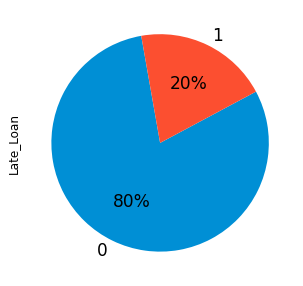

In [21]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 
plt.figure(figsize=(5,5))
df_sample['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [22]:
Amount_By_Year = df_sample.groupby(df_sample['issue_d'].dt.year)['loan_amnt'].mean()
Amount_By_Year = pd.DataFrame(Amount_By_Year)
Amount_By_Year['YoY Change %'] = Amount_By_Year.pct_change()*100
Amount_By_Year.rename(columns = {'loan_amnt':'Average Loan Amount'})

,Average Loan Amount,YoY Change %
issue_d,,
2012,13785.349643,NaN
2013,14853.968848,7.751847
2014,14787.742880,-0.445847
2015,14745.150463,-0.288025
2016,14546.627665,-1.346360
2017,14242.104176,-2.093430
2018,14984.659124,5.213801


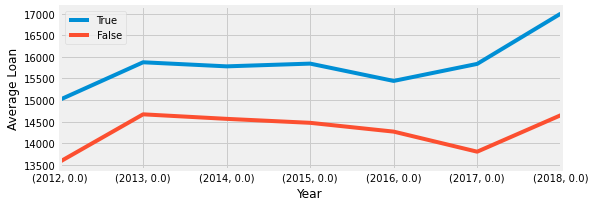

In [23]:
plt.figure(figsize=(8,3))
Amount_By_Year_Status_True = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == True]])['loan_amnt'].mean().plot(kind = 'line', label = 'True')
Amount_By_Year_Status_False = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == False]])['loan_amnt'].mean().plot(kind = 'line',label = 'False')
plt.xlabel('Year')
plt.ylabel('Average Loan')
plt.legend(loc='best')
plt.show()

In [24]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

df_sample['installmentAsPercent'] = df_sample['installment']/(df_sample['annual_inc']/12)

def GradeInt(x):
    if x == "A":
        return 1
    elif x == "B":
        return 2
    elif x == "C":
        return 3
    elif x == "D":
        return 4
    elif x == "E":
        return 5
    else:
        return 6

df_sample['GradeInt'] = df_sample['grade'].map(GradeInt)


Y,X = dmatrices('Late_Loan ~ 0 + int_rate + GradeInt + loan_amnt + installment + annual_inc + dti + delinq_2yrs + inq_last_6mths + open_acc + pub_rec + revol_bal + revol_util + total_acc + collections_12_mths_ex_med + acc_now_delinq + emp_length + term  + home_ownership + purpose + installmentAsPercent',df_sample, return_type = 'dataframe')
X_columns = X.columns

sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(X, Y)
X = pd.DataFrame(X,columns=X_columns)

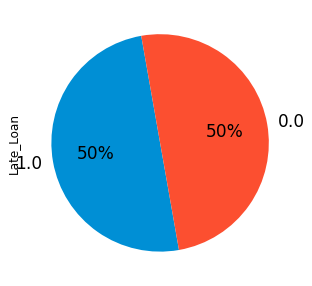

In [25]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 

Y_df = pd.DataFrame(Y,columns=['Late_Loan'])
plt.figure(figsize=(5,5))
Y_df['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

model = tree.DecisionTreeClassifier(criterion = 'entropy') 
param_dist = {    "max_depth": sp_randint(6,10),
                  "max_features": sp_randint(3,15),
                  "max_leaf_nodes": [10,20,30,40,50],
                  "min_samples_leaf": [25,50,75,100,150,250,500],
                 }
random_search = RandomizedSearchCV(model,
                        param_distributions=param_dist,
                        n_iter=50)

random_search.fit(X_train, Y_train)
print(random_search.best_score_)
print(random_search.best_estimator_)

0.8179506596887259
DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features=13,
                       max_leaf_nodes=50, min_samples_leaf=25)


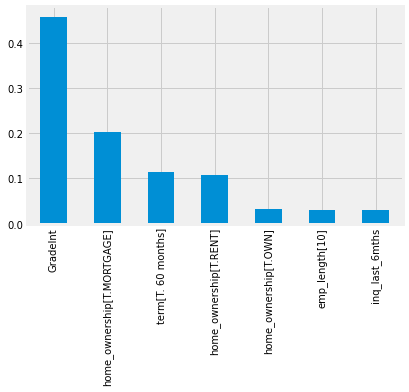

In [28]:
best_model = random_search.best_estimator_
best_model.fit(X_train,Y_train)

importance = sorted(zip(map(lambda x: round(x, 4), best_model.feature_importances_), X.columns),reverse=True)
y_val = []
x_val = [x[0] for x in importance]
for x in importance:
    y_val.append(x[1])
    
pd.Series(x_val,index=y_val)[:7].plot(kind='bar')
plt.show()

In [29]:
def print_report(test_y, test_predict):
    from sklearn.metrics import confusion_matrix
    
    
    print(confusion_matrix(test_y, test_predict))

    from sklearn.metrics import classification_report
    print(classification_report(test_y, test_predict))

In [32]:
from sklearn.linear_model import LogisticRegression

print('Fitting logistic regression model...')
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
log_reg.fit(X_train, Y_train)

print(round(log_reg.score(X_test, Y_test) * 100, 2), '%')

print('\nResults on train:')
print_report(Y_train, log_reg.predict(X_train))

print('\nResults on test:')
print_report(Y_test, log_reg.predict(X_test))

Fitting logistic regression model...
62.64 %

Results on train:
[[138699 116775]
 [ 74391 181013]]
              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59    255474
         1.0       0.61      0.71      0.65    255404

    accuracy                           0.63    510878
   macro avg       0.63      0.63      0.62    510878
weighted avg       0.63      0.63      0.62    510878


Results on test:
[[59321 50118]
 [31675 77834]]
              precision    recall  f1-score   support

         0.0       0.65      0.54      0.59    109439
         1.0       0.61      0.71      0.66    109509

    accuracy                           0.63    218948
   macro avg       0.63      0.63      0.62    218948
weighted avg       0.63      0.63      0.62    218948



In [1]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(best_model, random_state=1)
bagging.fit(X,Y)

accuracy = metrics.accuracy_score(bagging.predict(X_test),Y_test)
precision = metrics.precision_score(bagging.predict(X_test),Y_test,pos_label=1)
recall = metrics.recall_score(bagging.predict(X_test),Y_test,pos_label=1)
confusion_matrix = metrics.confusion_matrix(Y_test,bagging.predict(X_test),labels=[1,0])

print(accuracy)
print(precision)
print(recall)
print(confusion_matrix)

labels = ['Late', 'Paid']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'best_model' is not defined